# Forum Question Analyzer

In [1]:
# Load the dataset from the extracted .xml files.
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Forum Question Analyzer") \
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.17.0") \
    .getOrCreate()
posts = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "posts") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Posts.xml") \
    .alias('posts')
users = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "users") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Users.xml") \
    .alias('users')
tags = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rootTag", "tags") \
    .option("rowTag", "row") \
    .load("tex.stackexchange.com/Tags.xml") \
    .alias('tags')

## Descriptive Statistics

In [2]:
from pyspark.sql.functions import size, expr, when, col, explode
import matplotlib.pyplot as plt

In [3]:
questions = posts.filter(posts._PostTypeId == 1)
questions = questions.withColumn("tags", expr("split(substring(_Tags, 2, length(_Tags) - 2), '><')"))
questions = questions.withColumn("tag_number", size(questions.tags))

In [4]:
answers = posts.filter(posts._PostTypeId == 2)

In [5]:
print("Posts count: ", posts.count())
print("Questions: ", questions.count())
print("Answers: ", answers.count())
acc = questions.filter(questions._AcceptedAnswerId.isNotNull()).count()
print(f"Accepted answers: {acc} ({acc / questions.count()*100:.2f}% of questions and {acc / answers.count()*100:.2f}% of answers)")

Posts count:  584821
Questions:  255804
Answers:  326115
Accepted answers: 153808 (60.13% of questions and 47.16% of answers)


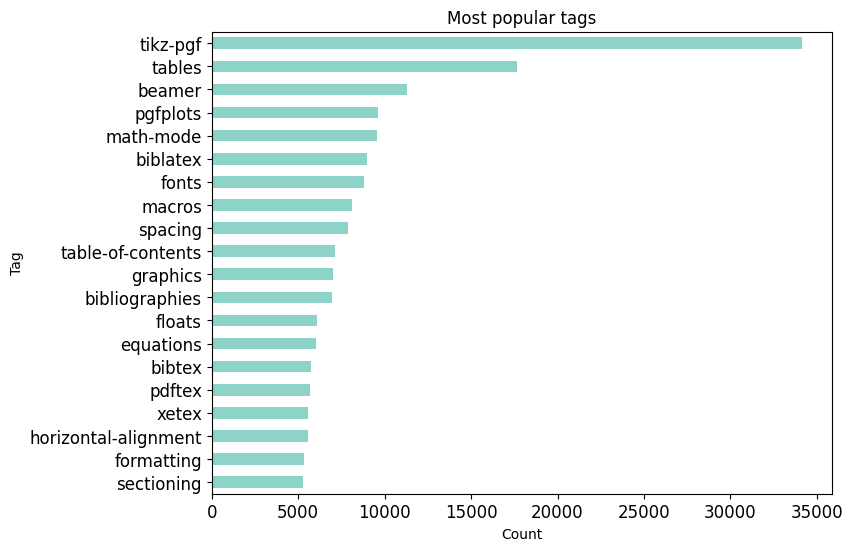

In [6]:
# Most popular tags
tags.select("_TagName", "_Count").orderBy("_Count", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="_TagName", y="_Count", title="Most popular tags",
              figsize=(8, 6), rot=0, legend=False, fontsize=12,
              colormap='Set3', xlabel="Count", ylabel="Tag")
plt.show()

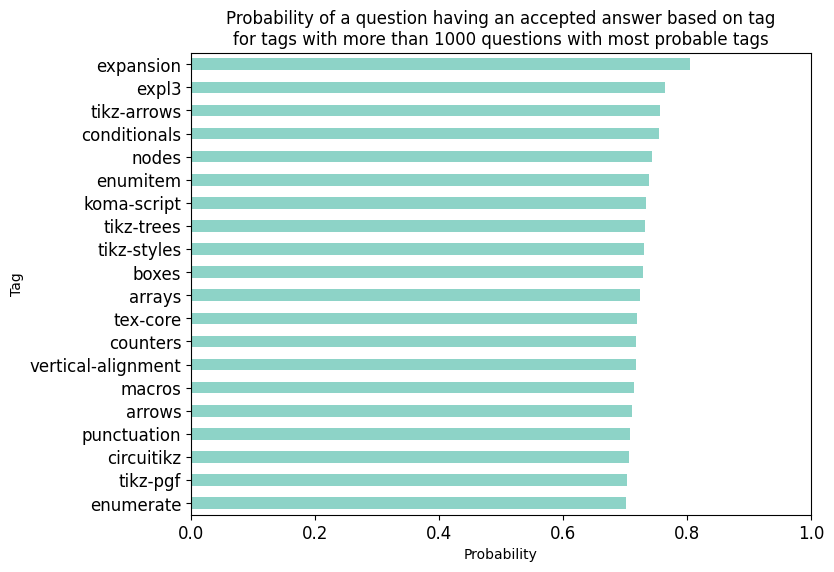

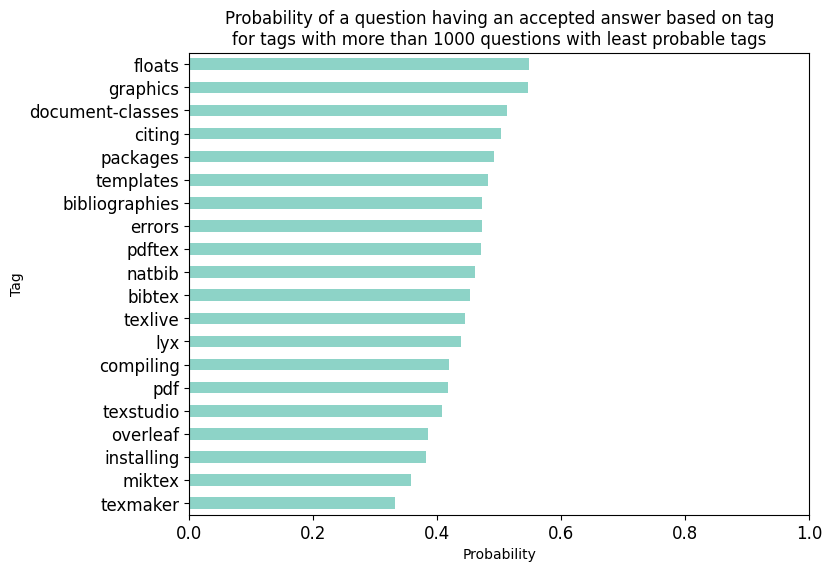

In [8]:
# Probability of a question having an accepted answer based on tag
questions = questions.withColumn("accepted", when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1))
questions_exploded = questions.select("*", explode(questions.tags).alias("tag"))
prob = questions_exploded.groupBy("tag").agg({"accepted": "avg"}).where("count(tag) > 1000")
prob.orderBy("avg(accepted)", ascending=False).limit(20).toPandas()[::-1] \
    .plot.barh(x="tag", y="avg(accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with most probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
prob.orderBy("avg(accepted)").limit(20).toPandas() \
    .plot.barh(x="tag", y="avg(accepted)",
               title="Probability of a question having an accepted answer based on tag\n"
                     "for tags with more than 1000 questions with least probable tags", 
               figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
               xlabel="Probability", ylabel="Tag", xlim=(0, 1))
plt.show()

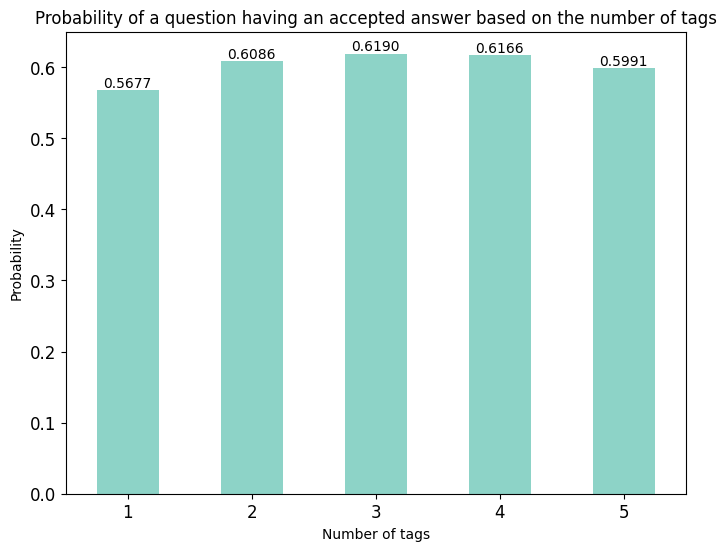

In [9]:
# Probability of a question having an accepted answer based on the tag number
ax = questions.groupBy("tag_number").agg({"accepted": "avg"}).orderBy("tag_number").toPandas() \
         .plot.bar(x="tag_number", y="avg(accepted)",
                   title="Probability of a question having an accepted answer based on the number of tags", 
                   figsize=(8, 6), rot=0, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Number of tags", ylabel="Probability")
ax.bar_label(ax.containers[0], fmt='%.4f')
plt.show()

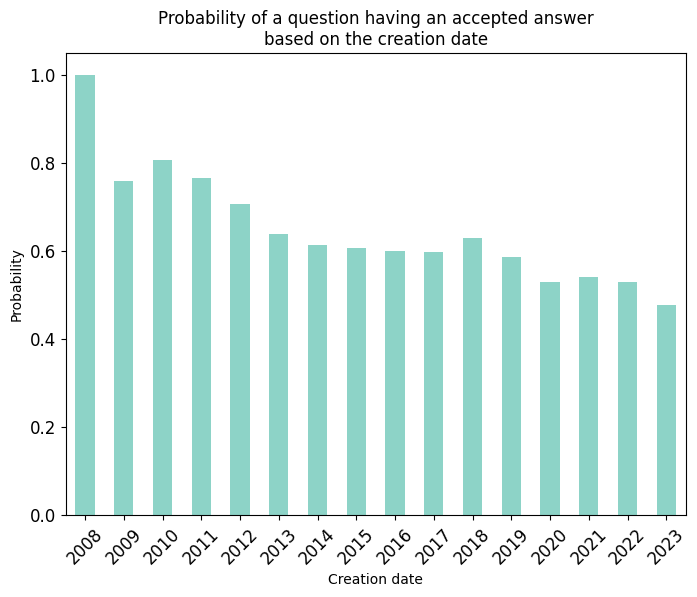

In [10]:
# Histogram of acceptance rate based on question creation date
questions = questions.withColumn("creation_date", expr("date_format(_CreationDate, 'yyyy')"))
ax = questions.groupBy("creation_date").agg({"accepted": "avg"}).orderBy("creation_date").toPandas() \
         .plot.bar(x="creation_date", y="avg(accepted)",
                   title="Probability of a question having an accepted answer\n"
                         "based on the creation date", 
                   figsize=(8, 6), rot=45, legend=False, fontsize=12, colormap='Set3',
                   xlabel="Creation date", ylabel="Probability")
plt.show()

## Logistic Regression

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Feature Extraction

In [12]:
features = ['_Score', '_ViewCount', '_AnswerCount', '_CommentCount']
assembler = VectorAssembler(inputCols=features, outputCol="features")

### Data Preparation

In [13]:
questions = posts.filter(posts._PostTypeId == 1)
questions = questions.withColumn("accepted", when(col("_AcceptedAnswerId").isNull(), 0).otherwise(1))

### Model Training

In [14]:
lr = LogisticRegression(labelCol="accepted", featuresCol="features")
pipeline = Pipeline(stages=[assembler, lr])
train, test = questions.randomSplit([0.7, 0.3], seed=12345)

In [15]:
model = pipeline.fit(train)

In [16]:
predictions = model.transform(test)

### Model Evaluation

In [17]:
evaluator = MulticlassClassificationEvaluator(labelCol="accepted", metricName="accuracy")
print("Test Accuracy: " + str(evaluator.evaluate(predictions)))

Test Accuracy: 0.742379177327809
